# Flights Data Analysis and prediction of Arrival Delay

Project Report : https://docs.google.com/document/d/1GYvwMFqH1Qw_z7RFLXGKIbsJ-odikoSBELj_W3u6CD0/edit

Slide Deck : https://docs.google.com/presentation/d/1fSttc3Hj_2mvxLYxMdJhMEwA7De7ulzzz9KPN5BFTIA/edit#slide=id.p

### Pyspark installation

In [2]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz

!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [95.7 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelea

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

### Data Acquisition

In [5]:
from google.colab import files
files.upload()

Saving 209846_458178_bundle_archive.zip to 209846_458178_bundle_archive.zip


In [6]:
!unzip 209846_458178_bundle_archive.zip

Archive:  209846_458178_bundle_archive.zip
  inflating: airports.csv            
  inflating: flights.csv             
  inflating: raw-flight-data.csv     


In [7]:
!ls

209846_458178_bundle_archive.zip  sample_data
airports.csv			  spark-3.0.0-bin-hadoop2.7
flights.csv			  spark-3.0.0-bin-hadoop2.7.tgz
raw-flight-data.csv


We shall be working with the flights.csv dataset to analyse flights delay and predict the same

In [8]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Reading in the Data

In [9]:
flights = spark.read.csv('flights.csv', inferSchema=True, header=True)
flights.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
|        19|        5|     DL|          10397|        15016|      -1|     -19|
|        19|        5|     DL|          15016|        10397|       0|      -1|
|        19|        5|     DL|          10397|        14869|      15|      24|
|        19|        5|     DL|          10397|        10423|      33|      34|
|        19|        5|     DL|          11278|      

Checking Data dimensions

In [11]:
print(flights.count(), len(flights.columns))

2702218 7


Checking inferred Schema

In [11]:
flights.printSchema()

root
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- OriginAirportID: integer (nullable = true)
 |-- DestAirportID: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)



Data Preparartion for Classification model : Created column label based on Arrival where I have assumed a flight taking more than 15 minutes to arrive is delayed and signified as 1 and arrivals within 15 minutes are 0

In [12]:
flights = flights.select("DayofMonth", "DayOfWeek", "Carrier", "OriginAirportID", "DestAirportID", "DepDelay","ArrDelay", ((col("ArrDelay") > 15).cast("Int").alias("label")))
flights.show(3)

+----------+---------+-------+---------------+-------------+--------+--------+-----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|label|
+----------+---------+-------+---------------+-------------+--------+--------+-----+
|        19|        5|     DL|          11433|        13303|      -3|       1|    0|
|        19|        5|     DL|          14869|        12478|       0|      -8|    0|
|        19|        5|     DL|          14057|        14869|      -4|     -15|    0|
+----------+---------+-------+---------------+-------------+--------+--------+-----+
only showing top 3 rows



### Exploratory Data Analysis

In [13]:
flights.describe().select("summary","DayofMonth", "DayOfWeek","DepDelay","ArrDelay","label").show()

+-------+------------------+-----------------+------------------+------------------+-------------------+
|summary|        DayofMonth|        DayOfWeek|          DepDelay|          ArrDelay|              label|
+-------+------------------+-----------------+------------------+------------------+-------------------+
|  count|           2702218|          2702218|           2702218|           2702218|            2702218|
|   mean|15.797897875004903|3.899480352806472|10.510732294729737|6.6550108096386005|0.19909792622208866|
| stddev|   8.7988350691642|1.985924603367557| 36.02975608466093|38.547584236791245| 0.3993219265282011|
|    min|                 1|                1|               -63|               -94|                  0|
|    max|                31|                7|              1863|              1845|                  1|
+-------+------------------+-----------------+------------------+------------------+-------------------+



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2702218


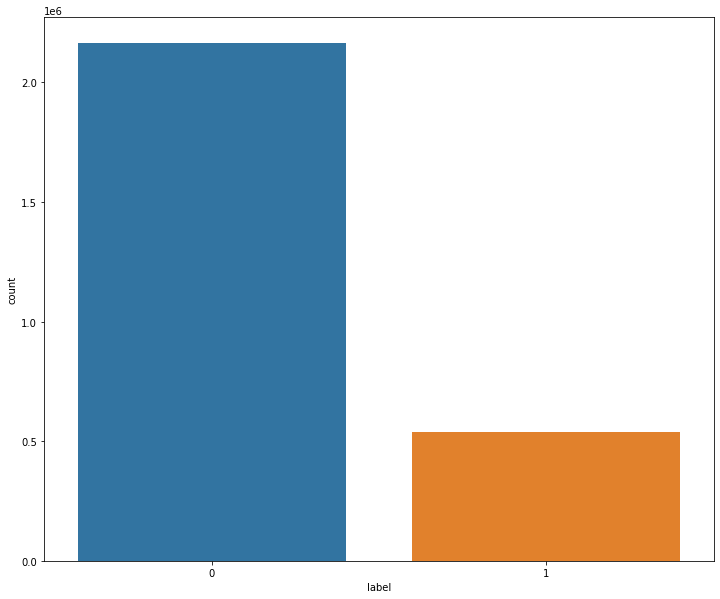

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_pd = flights.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='label', data=df_pd)

In [16]:
flights.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 538006|
|    0|2164212|
+-----+-------+



In [17]:
flights.groupBy('label').agg({'DepDelay':'mean'}).show()

+-----+-------------------+
|label|      avg(DepDelay)|
+-----+-------------------+
|    1|  54.14783849994238|
|    0|-0.3371074552770246|
+-----+-------------------+



In [15]:
flights.groupBy('label','DayofWeek').count().orderBy('count',ascending=False).show()

+-----+---------+------+
|label|DayofWeek| count|
+-----+---------+------+
|    0|        2|327758|
|    0|        1|324597|
|    0|        3|322517|
|    0|        4|308856|
|    0|        5|308497|
|    0|        7|302523|
|    0|        6|269464|
|    1|        4| 97707|
|    1|        5| 87890|
|    1|        1| 83240|
|    1|        3| 80555|
|    1|        2| 69836|
|    1|        7| 69705|
|    1|        6| 49073|
+-----+---------+------+



In [49]:
flights.groupBy('DayofMonth','label').count().orderBy('count',ascending=False).show(40)

+----------+-----+-----+
|DayofMonth|label|count|
+----------+-----+-----+
|        16|    0|76363|
|        30|    0|74576|
|        15|    0|74057|
|         6|    0|73774|
|         5|    0|73629|
|         3|    0|73268|
|        29|    0|72887|
|         4|    0|72434|
|         2|    0|71721|
|         9|    0|71501|
|         8|    0|71418|
|        23|    0|71320|
|        25|    0|71165|
|        27|    0|71084|
|        17|    0|71081|
|        14|    0|70900|
|         7|    0|70815|
|        24|    0|70750|
|        20|    0|70353|
|        26|    0|70189|
|        21|    0|69168|
|         1|    0|68990|
|        28|    0|68527|
|        12|    0|68467|
|        11|    0|68450|
|        19|    0|68088|
|        18|    0|67960|
|        22|    0|67938|
|        13|    0|66948|
|        10|    0|66870|
|        31|    0|39521|
|        10|    1|23155|
|        22|    1|21337|
|        19|    1|20966|
|        18|    1|20944|
|        12|    1|20390|
|        13|    1|20165|


In [16]:
flights.show(2)

+----------+---------+-------+---------------+-------------+--------+-----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|label|
+----------+---------+-------+---------------+-------------+--------+-----+
|        19|        5|     DL|          11433|        13303|      -3|    0|
|        19|        5|     DL|          14869|        12478|       0|    0|
+----------+---------+-------+---------------+-------------+--------+-----+
only showing top 2 rows



In [17]:
flights.groupBy('Carrier').count().orderBy('count',ascending=False).show()

+-------+------+
|Carrier| count|
+-------+------+
|     WN|575739|
|     DL|381657|
|     AA|289855|
|     UA|286418|
|     US|233321|
|     OO|160164|
|     EV|157928|
|     B6|121906|
|     MQ|113212|
|     FL| 92702|
|     9E| 80031|
|     AS| 68555|
|     YV| 52821|
|     F9| 35738|
|     VX| 34739|
|     HA| 17432|
+-------+------+



In [52]:
flights.groupBy('Carrier').agg({'DepDelay':'mean'}).orderBy('avg(DepDelay)',ascending=False).show()

+-------+------------------+
|Carrier|     avg(DepDelay)|
+-------+------------------+
|     MQ|15.050197858884218|
|     VX|14.386251763148048|
|     EV|14.137537358796413|
|     WN|12.846166405263496|
|     B6|12.619797220809476|
|     UA|12.545388208841622|
|     F9|12.123454026526387|
|     AA| 12.00779700194925|
|     FL| 10.16288753209208|
|     9E| 9.510189801451938|
|     YV| 9.385755665360367|
|     OO| 7.826939886616218|
|     DL| 7.439483620109155|
|     US| 4.974331500379305|
|     HA| 1.533903166590179|
|     AS|0.6592371088906718|
+-------+------------------+



In [20]:
flights.groupBy('Carrier').agg({'ArrDelay':'mean'}).orderBy('avg(ArrDelay)',ascending=False).show()

+-------+--------------------+
|Carrier|       avg(ArrDelay)|
+-------+--------------------+
|     MQ|  13.731132742112143|
|     F9|  12.848704460238402|
|     EV|  10.205865964236867|
|     VX|    9.65790609977259|
|     B6|   9.634792381014881|
|     YV|   8.547585240718654|
|     WN|   8.313306897743596|
|     FL|   7.228765290932235|
|     AA|  7.1367752841938215|
|     OO|   6.339957793261907|
|     UA|   5.163631475675412|
|     9E|  4.7892066824105655|
|     US|   3.924031698818366|
|     DL|   2.803331263411912|
|     HA|  1.5321248279027078|
|     AS|-0.27210269126978337|
+-------+--------------------+



In [45]:
flights.groupBy('Carrier','label').count().orderBy('count',ascending=False).show()

+-------+-----+------+
|Carrier|label| count|
+-------+-----+------+
|     WN|    0|448138|
|     DL|    0|323989|
|     AA|    0|230013|
|     UA|    0|229051|
|     US|    0|192378|
|     OO|    0|130938|
|     WN|    1|127601|
|     EV|    0|120690|
|     B6|    0| 92771|
|     MQ|    0| 82871|
|     FL|    0| 74056|
|     9E|    0| 65568|
|     AS|    0| 60824|
|     AA|    1| 59842|
|     DL|    1| 57668|
|     UA|    1| 57367|
|     YV|    0| 42604|
|     US|    1| 40943|
|     EV|    1| 37238|
|     MQ|    1| 30341|
+-------+-----+------+
only showing top 20 rows



In [15]:
df_pd.head(2)

,DayofMonth,DayOfWeek,Carrier,OriginAirportID,DestAirportID,DepDelay,ArrDelay,label
0,19,5,DL,11433,13303,-3,1,0
1,19,5,DL,14869,12478,0,-8,0


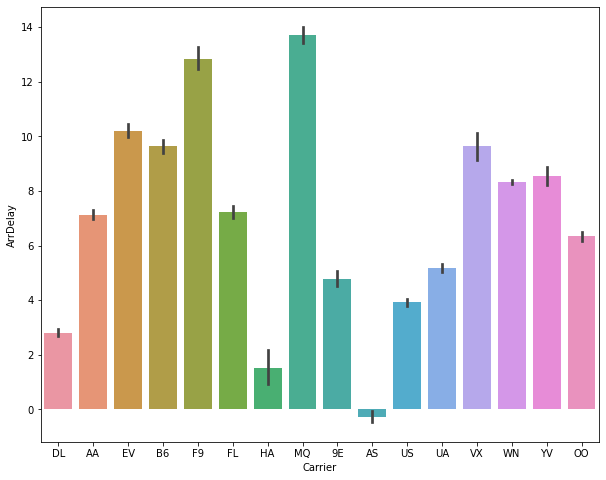

In [22]:
from numpy import mean
plt.figure(figsize=(10,8))
sns.barplot(x='Carrier', y='ArrDelay', data=df_pd,estimator=mean)
plt.show()

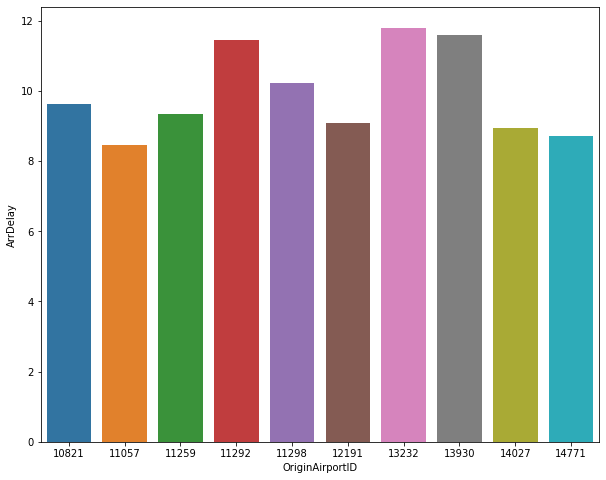

In [33]:
x = df_pd.groupby('OriginAirportID').agg({'ArrDelay':'mean'}).sort_values(by='ArrDelay', ascending=False).head(10)
plt.figure(figsize=(10,8))
sns.barplot(x=x.index, y='ArrDelay', data=x)
plt.show()

In [19]:
flights.groupBy('DayOfWeek').agg({'DepDelay':'mean'}).show()

+---------+------------------+
|DayOfWeek|     avg(DepDelay)|
+---------+------------------+
|        1|10.850131302456619|
|        6| 7.447128591027102|
|        3| 10.38794805890759|
|        5| 12.30982600337549|
|        4| 13.61391469464757|
|        7| 9.614650160654223|
|        2| 8.613603323993823|
+---------+------------------+



In [23]:
flights.agg(*(countDistinct(col(c)).alias(c) for c in flights.columns)).show()

+----------+---------+-------+---------------+-------------+--------+--------+-----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|label|
+----------+---------+-------+---------------+-------------+--------+--------+-----+
|        31|        7|     16|             70|           70|     945|     979|    2|
+----------+---------+-------+---------------+-------------+--------+--------+-----+



In [19]:
flights.groupBy('OriginAirportID').agg({'DepDelay':'mean'}).orderBy('avg(DepDelay)',ascending=False).show()

+---------------+------------------+
|OriginAirportID|     avg(DepDelay)|
+---------------+------------------+
|          13232| 16.12861852685751|
|          13930| 15.68016038366288|
|          11618|14.552501049554522|
|          11292|14.463062544340369|
|          11298|14.186065023496692|
|          10821|  13.6921813720755|
|          12478|13.542426803201273|
|          14771|13.493117850870949|
|          12191|13.146877050029348|
|          12264| 13.00887012744129|
|          12889|11.884909730604278|
|          11259|11.794565103346972|
|          14027|11.522148449113072|
|          15016|11.335349807930795|
|          11697|11.219662631246772|
|          12266|11.198115780001636|
|          12953|11.147533593411357|
|          14730| 11.14732020155749|
|          10397|10.923056211842788|
|          13204|10.868233219741281|
+---------------+------------------+
only showing top 20 rows



In [10]:
flights.groupBy('OriginAirportID').agg({'ArrDelay':'mean'}).orderBy('avg(ArrDelay)',ascending=False).show()

+---------------+------------------+
|OriginAirportID|     avg(ArrDelay)|
+---------------+------------------+
|          13232|11.806288195561274|
|          13930|11.595141318448052|
|          11292|11.441419303097915|
|          11298|10.230449793804546|
|          10821| 9.631479299086184|
|          11259| 9.340258105130626|
|          12191| 9.076718571971135|
|          14027|   8.9501536022198|
|          14771| 8.712943186672362|
|          11057| 8.462015301118159|
|          12264| 8.406449544470865|
|          11697|  8.35816742211257|
|          14843| 8.353468208092485|
|          14730| 8.180485570316078|
|          12889| 8.100272220652815|
|          11066| 7.780932474017303|
|          15016|  7.32140588608935|
|          10693| 7.299220300946572|
|          11618| 7.292584702937198|
|          13851|6.9440453957764685|
+---------------+------------------+
only showing top 20 rows



In [22]:
flights.groupBy('Carrier').agg({'ArrDelay':'mean'}).orderBy('avg(ArrDelay)',ascending=False).show()

+-------+--------------------+
|Carrier|       avg(ArrDelay)|
+-------+--------------------+
|     MQ|  13.731132742112143|
|     F9|  12.848704460238402|
|     EV|  10.205865964236867|
|     VX|    9.65790609977259|
|     B6|   9.634792381014881|
|     YV|   8.547585240718654|
|     WN|   8.313306897743596|
|     FL|   7.228765290932235|
|     AA|  7.1367752841938215|
|     OO|   6.339957793261907|
|     UA|   5.163631475675412|
|     9E|  4.7892066824105655|
|     US|   3.924031698818366|
|     DL|   2.803331263411912|
|     HA|  1.5321248279027078|
|     AS|-0.27210269126978337|
+-------+--------------------+



### Feature Engineering and Data preparation for Modelling

In [36]:
splits = flights.randomSplit([0.7, 0.3])
train = splits[0]
test = splits[1].withColumnRenamed("label", "trueLabel")
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 1889745  Testing Rows: 812473


Pipeline for Preprocessing :

*   A StringIndexer estimator that converts string values to indexes for categorical features
*   A VectorAssembler that combines categorical features into a single vector
*   A VectorIndexer that creates indexes for a vector of categorical features
*   A VectorAssembler that creates a vector of continuous numeric features
*   A MinMaxScaler that normalizes continuous numeric features
*   A VectorAssembler that creates a vector of categorical and continuous features
*   A LogisticRegressionClassifier that trains a classification model.









In [35]:
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")
lr = LogisticRegression(labelCol="label",featuresCol="features",maxIter=10,regParam=0.3)
#dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_LR = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect, lr])

Fitting Training Data to pipeline

In [24]:
piplineModel_LR = pipelineLR.fit(train)

In [25]:
prediction = piplineModel_LR.transform(test)
predicted = prediction.select("features", "prediction", "trueLabel")

In [26]:
predicted.show(10)

+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        1|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
+--------------------+----------+---------+
only showing top 10 rows



### Evaluating the Model
We'll calculate a Confusion Matrix and the Area Under ROC (Receiver Operating Characteristic) to evaluate the model.

In [27]:
tp = float(predicted.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(predicted.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(predicted.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(predicted.filter("prediction == 0.0 AND truelabel == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            19572.0|
|       FP|               74.0|
|       TN|           649853.0|
|       FN|           141618.0|
|Precision| 0.9962333299399369|
|   Recall|0.12142192443699981|
|       F1|0.21646132407264038|
+---------+-------------------+



We have good precision in our model but recall is poor hence our F1 score is too low 

In [28]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
aur = evaluator.evaluate(prediction)
print ("AUR = ", aur)

AUR =  0.9189409704690327


The prediction is based on a raw prediction score that describes a labelled point in a logistic function. This raw prediction is then converted to a predicted label of 0 or 1 based on a probability vector that indicates the confidence for each possible label value (in this case, 0 and 1). The value with the highest confidence is selected as the prediction.

In [29]:
prediction.select("rawPrediction", "probability", "prediction", "trueLabel").show(10, truncate=False)

+----------------------------------------+----------------------------------------+----------+---------+
|rawPrediction                           |probability                             |prediction|trueLabel|
+----------------------------------------+----------------------------------------+----------+---------+
|[1.535155677776856,-1.535155677776856]  |[0.8227593994875413,0.17724060051245877]|0.0       |0        |
|[1.2150397981219756,-1.2150397981219756]|[0.7711894682598593,0.22881053174014074]|0.0       |0        |
|[1.2451878908004512,-1.2451878908004512]|[0.7764657506114899,0.22353424938851008]|0.0       |1        |
|[1.580330210752271,-1.580330210752271]  |[0.8292512787888032,0.1707487212111968] |0.0       |0        |
|[1.6018671254797334,-1.6018671254797334]|[0.8322791799233202,0.16772082007667982]|0.0       |0        |
|[1.587949043755608,-1.587949043755608]  |[0.830327352199962,0.16967264780003796] |0.0       |0        |
|[1.6869515237821997,-1.6869515237821997]|[0.8438228347

Let's create similar pipeline for our Decision Tree Model

In [32]:
strIdx = StringIndexer(inputCol = "Carrier", outputCol = "CarrierIdx")
catVect = VectorAssembler(inputCols = ["CarrierIdx", "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")
numVect = VectorAssembler(inputCols = ["DepDelay"], outputCol="numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pipeline_dt = Pipeline(stages=[strIdx, catVect, catIdx, numVect, minMax, featVect, dt])

Fitting Decision Tree Pipeline

In [ ]:
piplineModel_DT = pipeline_dt.fit(train)

In [37]:
prediction_DT = piplineModel_DT.transform(test)
predicted_DT = prediction_DT.select("features", "prediction", "trueLabel")

In [38]:
predicted_DT.show(10)

+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        1|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
|[10.0,1.0,0.0,105...|       0.0|        0|
+--------------------+----------+---------+
only showing top 10 rows



Evaluation Metrics for Decision Tree

In [40]:
tp = float(predicted_DT.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(predicted_DT.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(predicted_DT.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(predicted_DT.filter("prediction == 0.0 AND truelabel == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          114102.0|
|       FP|           12430.0|
|       TN|          637497.0|
|       FN|           47088.0|
|Precision|0.9017639806531155|
|   Recall|0.7078726968174205|
|       F1|0.7931406009967955|
+---------+------------------+



In [43]:
evaluator = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
aur = evaluator.evaluate(prediction_DT)
print ("AUR = ", aur)

AUR =  0.8443737359922389


As we can see even with a much better recall than the Logistic Regression Model the Decision Tree's Area Under ROC curve is lesser which signifies that as an overall Model The Logistic Regression is performing better.

### Hyperparamter Tuning for Logistic Regression Model
To find the best performing parameters, we can use the CrossValidator class to evaluate each combination of parameters defined in a ParameterGrid against multiple folds of the data split into training and validation datasets.

### Change the Discrimination Threshold

The AUC score seems to indicate a reasonably good model, but the performance metrics seem to indicate that it predicts a high number of False Negative labels (i.e. it predicts 0 when the true label is 1), leading to a low Recall. We can improve this by lowering the threshold. 

In this case, I'll let the CrossValidator find the best threshold from 0.4 and 0.3, regularization parameter from 0.3 and 0.1, and the maximum number of iterations allowed from 10 and 5.

In [38]:
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.3, 0.1]).addGrid(lr.maxIter, [10, 5]).addGrid(lr.threshold, 
                                                                                            [0.4, 0.3]).build()
cv = CrossValidator(estimator=pipeline_LR, evaluator=BinaryClassificationEvaluator(), estimatorParamMaps=paramGrid, 
                    numFolds=2)

model = cv.fit(train)

In [39]:
newPrediction = model.transform(test)
newPredicted = newPrediction.select("features", "prediction", "trueLabel")
newPredicted.show(10)

+--------------------+----------+---------+
|            features|prediction|trueLabel|
+--------------------+----------+---------+
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,103...|       1.0|        1|
|[10.0,1.0,0.0,103...|       0.0|        0|
|[10.0,1.0,0.0,104...|       0.0|        0|
|[10.0,1.0,0.0,106...|       0.0|        0|
|[10.0,1.0,0.0,106...|       1.0|        1|
|[10.0,1.0,0.0,107...|       0.0|        0|
|[10.0,1.0,0.0,107...|       0.0|        0|
|[10.0,1.0,0.0,107...|       0.0|        1|
+--------------------+----------+---------+
only showing top 10 rows



In [40]:
tp = float(newPredicted.filter("prediction == 1.0 AND truelabel == 1").count())
fp = float(newPredicted.filter("prediction == 1.0 AND truelabel == 0").count())
tn = float(newPredicted.filter("prediction == 0.0 AND truelabel == 0").count())
fn = float(newPredicted.filter("prediction == 0.0 AND truelabel == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|            31492.0|
|       FP|              110.0|
|       TN|           650187.0|
|       FN|           130684.0|
|Precision| 0.9965192076450857|
|   Recall| 0.1941840962904499|
|       F1|0.32503173734892504|
+---------+-------------------+



In [42]:
# Recalculate the Area Under ROC
evaluator2 = BinaryClassificationEvaluator(labelCol="trueLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
aur2 = evaluator2.evaluate(newPredicted)
print( "AUR2 = ", aur2)

AUR2 =  0.5970074714056737
